# 01 -- Exploratory Data Analysis (EDA)

**Project:** NLP Feature Extraction & Product Categorization

**Objective:** Understand the structure and characteristics of Polish e-commerce product data
before building the feature extraction and categorization pipeline.

**Key questions:**
1. What does the product naming convention look like? (lengths, word counts, common tokens)
2. What is the distribution of prices and how do they relate to product types?
3. How much structured information can we extract from free-text product names?
4. What patterns exist in SKU codes and seller comments?
5. Which extracted features have the best coverage?

In [1]:
import sys
import os
from pathlib import Path

sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import yaml

from src.etl import run_etl
from src.text_preprocessing import preprocess_dataframe, normalize_text, tokenize, remove_stopwords
from src.feature_extraction import FeatureExtractor

pio.renderers.default = "notebook+png"

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", "{:.2f}".format)

# Paths
PROJECT_ROOT = Path("..").resolve()
IMG_DIR = PROJECT_ROOT / "notebooks" / "img"
IMG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/mlipieclocal/Library/CloudStorage/SynologyDrive-MiM/Dokumenty/Programowanie/Projekty/ML_in_E_Commerce/NLP_Feature_Extraction_and_Product_Categorization


In [2]:
# Load config
with open(PROJECT_ROOT / "config.yaml") as f:
    config = yaml.safe_load(f)

# Load data -- run ETL if parquet not available
items_path = PROJECT_ROOT / config["data"]["items_parquet"]

if items_path.exists():
    df = pd.read_parquet(items_path)
    print(f"Loaded {len(df)} items from {items_path.name}")
else:
    print("Parquet not found -- running ETL...")
    df = run_etl(
        raw_dir=config["data"]["raw_dir"],
        output_path=str(items_path),
        pattern=config["data"].get("xml_glob", "*.xml"),
    )
    print(f"ETL complete: {len(df)} items.")

df.head()

Loaded 9879 items from items.parquet


item_id   order_id  \
0  4b0eca669010a75d  791880451   
1  ee311fc81d82c1bd  791880302   
2  ad3e39cca4bd2723  791878538   
3  36c61dcd89446f81  791858697   
4  a3ba4c36cff24abb  791843871   

                                                name  \
0  TAUPE KLASYCZNE KOWBOJKI ZA KOSTKĘ NA ZAMEK SK...   
1  CZARNY MAŁY PORTFEL MONNARI PORTMONETKA SKÓRZA...   
2  KAMELOWE BRĄZOWE BOTKI PÓŁBUTY WĘŻOWE CHOLEWKI 36   
3  CZARNA TOREBKA MONNARI NA RAMIĘ OZDOBNY GEOMET...   
4               Trapery, Glany w Czachy Czaszki - 38   

               products_sku            date_add     payment_name  \
0         OPT-611-OC-CAP-41 2025-11-02 18:38:41  Allegro Finance   
1        MON-PUR0162-020-24 2025-11-02 18:38:50  Allegro Finance   
2  BD-BTZ-LICO-WAZ-KAMEL-36 2025-11-02 18:31:24  Allegro Finance   
3           MON-BAG1360-M20 2025-11-02 17:06:59  Allegro Finance   
4             bota19-016-38 2025-11-02 15:53:38       Przelewy24   

                                       delivery_type  \
0                        Allegro One Box, One Kurier   
1  Allegro Wysyłka z Polski do Słowacji - Automat...   
2                          Allegro Paczkomaty InPost   
3                          Allegro Paczkomaty InPost   
4                                  Paczkomaty InPost   

                 client_city  order_amount_brutto  \
0                   Warszawa               211.59   
1                 Vikartovce                23.33   
2                Ciecierzyce               282.20   
3                      Serby               110.39   
4  Zajączki Drugie, Krzepice               399.00   

                                     seller_comments buyer_comments  \
0  reklamacja rozpruwa sie szew, troche naciągnie...            NaN   
1                                                NaN            NaN   
2                                                NaN            NaN   
3                                                NaN            NaN   
4                                           stan zm.            NaN   

     products_id   products_ean      auction_id  item_price_brutto  quantity  \
0           5226            NaN     15120470896             211.59         1   
1           6449  5904528942505     16789307461              23.33         1   
2           4502            NaN     16283818887             282.20         1   
3           6513  5906959005095     17315188503             110.39         1   
4  4442801504309  8434706013477  17651202883924             399.00         1   

   amount_brutto  vat_rate         symkar  
0         211.59     23.00           5226  
1          23.33     23.00           6449  
2         282.20     23.00           4502  
3         110.39     23.00           6513  
4         399.00     23.00  4442801504309

## 1. Dataset Overview

In [3]:
# Shape, dtypes, sample rows
print(f"Shape: {df.shape[0]:,} items x {df.shape[1]} columns\n")
print("Column types:")
print(df.dtypes.to_string())
print("\nSample rows:")
df.sample(5, random_state=42)

Shape: 9,879 items x 19 columns

Column types:
item_id                           str
order_id                          str
name                              str
products_sku                      str
date_add               datetime64[us]
payment_name                      str
delivery_type                     str
client_city                       str
order_amount_brutto           float64
seller_comments                   str
buyer_comments                    str
products_id                       str
products_ean                      str
auction_id                        str
item_price_brutto             float64
quantity                        int64
amount_brutto                 float64
vat_rate                      float64
symkar                            str

Sample rows:


item_id   order_id  \
4818  bba7ade3622c66c7  744773213   
952   fa49fa9e867d8edc  782458262   
9023  a79bc88b980f06cd  703255343   
5212  121ec2c3c8eb6eec  742399459   
7244  f98426f806488789  722919885   

                                                   name  \
4818  SNEAKERSY TENISÓWKI TRAMPKI DAMSKIE WEGAŃSKIE ...   
952   CZARNE BOTKI WORKERY NA PLATFORMIE WIĄZANE SKÓ...   
9023  BEŻOWE KOZAKI KOWBOJKI SZPIC ZAMSZOWE DO KOLAN...   
5212       BORDOWY PORTFEL MONNARI SKÓRZANY LAKIEROWANY   
7244         ZŁOTE SKÓRZANE BROKATOWE SZPILKI PIĘKNE 35   

                  products_sku            date_add     payment_name  \
4818              snk18-033-39 2025-03-18 15:51:17       Przelewy24   
952       BD-WOR1-GROCH-CZA-40 2025-09-16 11:01:29  Allegro Finance   
9023        WOL-D7891-BEIGE-38 2024-10-07 17:17:31       Przelewy24   
5212        MON-PUR0190-005-24 2025-03-08 11:22:52       Przelewy24   
7244  DA-DS-319-A-ZLOTY-BRO-35 2024-12-12 11:49:47       Przelewy24   

                    delivery_type       client_city  order_amount_brutto  \
4818    Allegro Paczkomaty InPost         Bydgoszcz               345.45   
952   Allegro One Box, One Kurier            Poznań               316.45   
9023    Allegro Paczkomaty InPost  Wodzisław Śląski               172.75   
5212                 ORLEN Paczka         Bydgoszcz               115.49   
7244    Allegro Paczkomaty InPost         Ostrołęka               251.79   

      seller_comments buyer_comments    products_id   products_ean  \
4818              NaN            NaN  4308881571893  8434706008985   
952               NaN            NaN           5223            NaN   
9023              NaN     ROZMIAR 38          70292            NaN   
5212  Stan na IS zmn.            NaN           6458  5904528942673   
7244              NaN            NaN           3094            NaN   

       auction_id  item_price_brutto  quantity  amount_brutto  vat_rate  \
4818  17146541344             345.45         1         345.45     23.00   
952   16389205249             316.45         1         316.45     23.00   
9023  16200126822             172.75         1         172.75     23.00   
5212  16789550052             115.49         1         115.49     23.00   
7244  16572154067             251.79         1         251.79     23.00   

             symkar  
4818  4308881571893  
952            5223  
9023          70292  
5212           6458  
7244           3094

In [4]:
# Missing values analysis
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_df = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})
missing_df = missing_df[missing_df["missing_count"] > 0].sort_values("missing_count", ascending=False)

print(f"Columns with missing values: {len(missing_df)} / {len(df.columns)}\n")
missing_df

Columns with missing values: 14 / 19



missing_count  missing_pct
buyer_comments              9736        98.60
seller_comments             7406        75.00
products_ean                5250        53.10
auction_id                  3536        35.80
products_id                  205         2.10
symkar                       205         2.10
products_sku                 160         1.60
payment_name                 128         1.30
client_city                  107         1.10
name                          23         0.20
item_price_brutto             23         0.20
amount_brutto                 23         0.20
vat_rate                      23         0.20
delivery_type                 18         0.20

## 2. Product Name Analysis

Product names are the primary source for NLP feature extraction.
Let's understand their structure: length, word count, and common patterns.

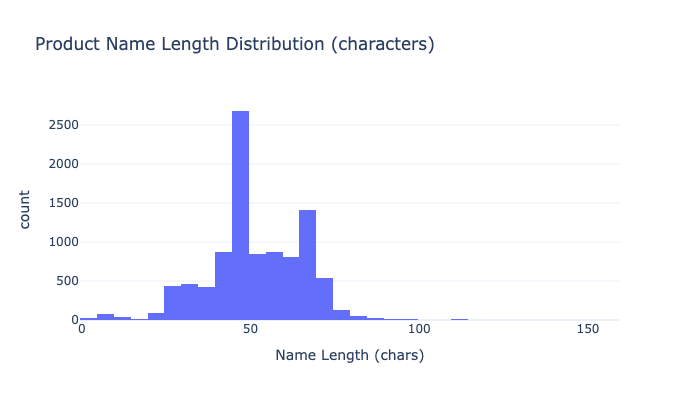

Name length -- mean: 51.5, median: 49, min: 0, max: 157


In [5]:
# Compute name length and word count on raw names
names = df["name"].fillna("").astype(str)
df["_name_len"] = names.str.len()
df["_word_count"] = names.str.split().str.len().fillna(0).astype(int)

# Name length distribution
fig = px.histogram(
    df, x="_name_len", nbins=60,
    title="Product Name Length Distribution (characters)",
    labels={"_name_len": "Name Length (chars)", "count": "Count"},
    template="plotly_white",
)
fig.update_layout(height=400)
fig.write_image(str(IMG_DIR / "name_length_dist.png"), scale=2)
fig.show()

print(f"Name length -- mean: {df['_name_len'].mean():.1f}, "
      f"median: {df['_name_len'].median():.0f}, "
      f"min: {df['_name_len'].min()}, max: {df['_name_len'].max()}")

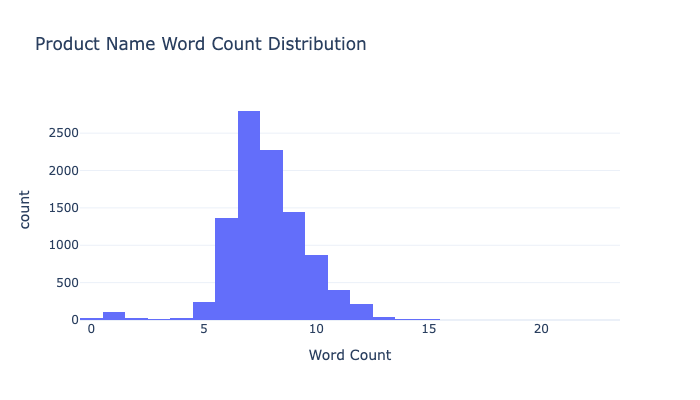

Word count -- mean: 7.8, median: 8, min: 0, max: 23


In [6]:
# Word count distribution
fig = px.histogram(
    df, x="_word_count", nbins=30,
    title="Product Name Word Count Distribution",
    labels={"_word_count": "Word Count", "count": "Count"},
    template="plotly_white",
)
fig.update_layout(height=400)
fig.write_image(str(IMG_DIR / "word_count_dist.png"), scale=2)
fig.show()

print(f"Word count -- mean: {df['_word_count'].mean():.1f}, "
      f"median: {df['_word_count'].median():.0f}, "
      f"min: {df['_word_count'].min()}, max: {df['_word_count'].max()}")

In [7]:
# Quick look at shortest and longest names
print("Shortest names (by character count):")
for name in df.nsmallest(5, "_name_len")["name"].values:
    print(f"  [{len(str(name))} chars] {name}")

print("\nLongest names (by character count):")
for name in df.nlargest(5, "_name_len")["name"].values:
    print(f"  [{len(str(name))} chars] {name}")

Shortest names (by character count):
  [3 chars] nan
  [3 chars] nan
  [3 chars] nan
  [3 chars] nan
  [3 chars] nan

Longest names (by character count):
  [157 chars] JASNE BEŻOWE NUBUKOWE KOZAKI DO KOLANA PLATFORMY NA KLOCKU OCIEPLANE Kozaki do kolana na platformie na klocku ocieplane nubukowe beżowe Sergio Leone KZ930-37
  [148 chars] Kozaki do kolana na platformie na płaskim obcasie czarne Sergio Leone KZ741 Kozaki do kolana na platformie na płaskim obcasie czarne Sergio Leone-40
  [132 chars] Półbuty na klocku ze srebrną ozdobą skórzane lakierowane czarne Sempre Półbuty na klocku ze srebrną ozdobą skórzane czarne Sempre-38
  [131 chars] ZŁOTE POŁYSKUJĄCE CZÓŁENKA ŚLUBNE NA WESELE WYCIĘCIA KLAMERKA BUTDAM Czółenka z klamerką i wycięciami skórzane złote Butdam Mila-38
  [131 chars] ZŁOTE POŁYSKUJĄCE CZÓŁENKA ŚLUBNE NA WESELE WYCIĘCIA KLAMERKA BUTDAM Czółenka z klamerką i wycięciami skórzane złote Butdam Mila-37


## 3. Word Frequency Analysis

Tokenize and count the most common words in product names to understand
the vocabulary used in this Polish e-commerce catalog.

Total tokens: 66,264
Unique tokens: 1,359


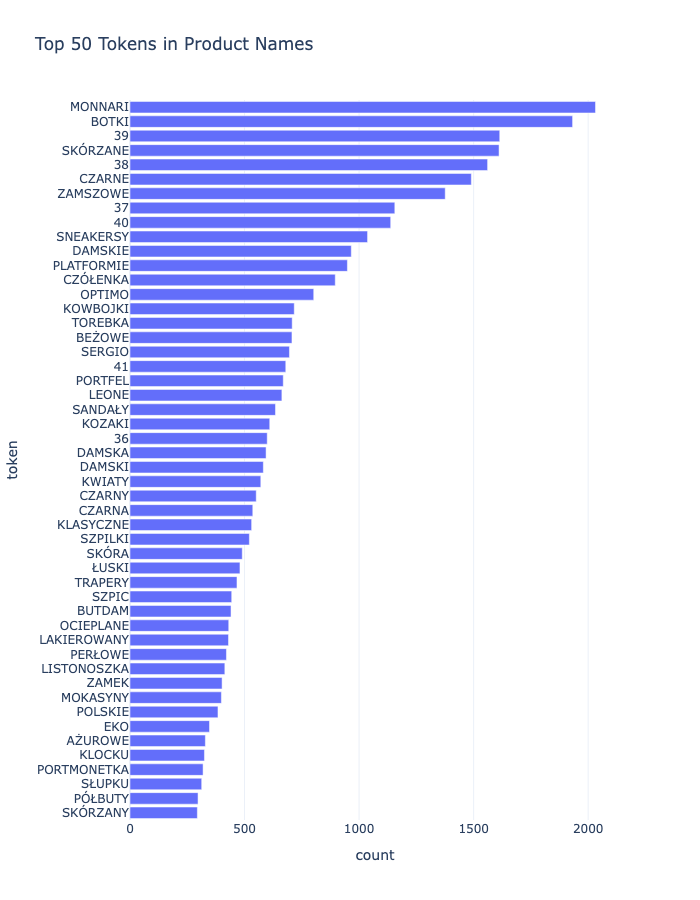

In [8]:
# Normalize and tokenize all product names
all_tokens = []
for name in df["name"].dropna():
    normalized = normalize_text(name)
    tokens = tokenize(normalized, min_length=2)
    tokens = remove_stopwords(tokens)
    all_tokens.extend(tokens)

token_counts = Counter(all_tokens)
print(f"Total tokens: {len(all_tokens):,}")
print(f"Unique tokens: {len(token_counts):,}")

# Top 50 tokens bar chart
top50 = token_counts.most_common(50)
top50_df = pd.DataFrame(top50, columns=["token", "count"])

fig = px.bar(
    top50_df, x="count", y="token", orientation="h",
    title="Top 50 Tokens in Product Names",
    template="plotly_white",
)
fig.update_layout(height=900, yaxis=dict(autorange="reversed"))
fig.write_image(str(IMG_DIR / "top50_tokens.png"), scale=2)
fig.show()

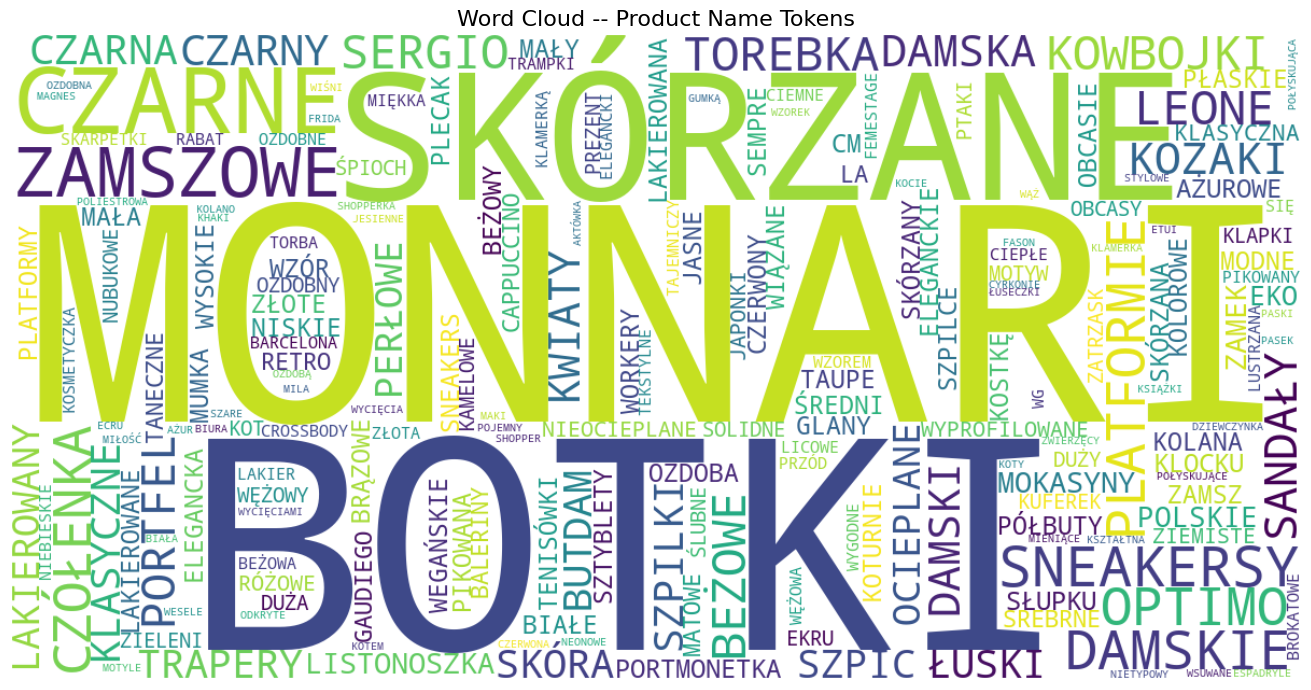

In [9]:
# WordCloud -- Polish product name vocabulary
wc_text = " ".join(all_tokens)

wc = WordCloud(
    width=1200, height=600,
    background_color="white",
    max_words=200,
    colormap="viridis",
    collocations=False,
)
wc.generate(wc_text)

fig_mpl, ax = plt.subplots(figsize=(14, 7))
ax.imshow(wc, interpolation="bilinear")
ax.axis("off")
ax.set_title("Word Cloud -- Product Name Tokens", fontsize=16)
fig_mpl.tight_layout()
fig_mpl.savefig(str(IMG_DIR / "wordcloud.png"), dpi=150, bbox_inches="tight")
plt.show()

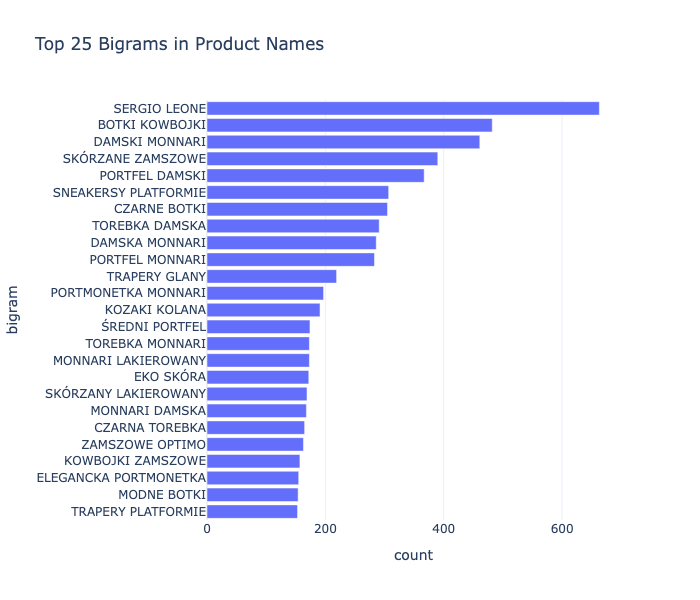

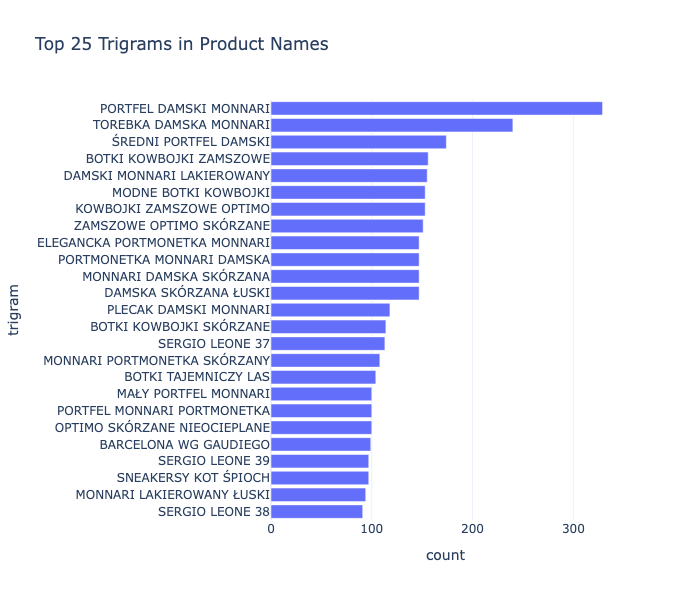

In [10]:
# N-gram analysis: bigrams and trigrams
from itertools import islice

def ngrams(tokens, n):
    """Generate n-grams from a token list."""
    return [" ".join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

# Build bigrams and trigrams per product name
all_bigrams = []
all_trigrams = []
for name in df["name"].dropna():
    normalized = normalize_text(name)
    tokens = tokenize(normalized, min_length=2)
    tokens = remove_stopwords(tokens)
    all_bigrams.extend(ngrams(tokens, 2))
    all_trigrams.extend(ngrams(tokens, 3))

# Top 25 bigrams
bigram_counts = Counter(all_bigrams).most_common(25)
bi_df = pd.DataFrame(bigram_counts, columns=["bigram", "count"])

fig_bi = px.bar(
    bi_df, x="count", y="bigram", orientation="h",
    title="Top 25 Bigrams in Product Names",
    template="plotly_white",
)
fig_bi.update_layout(height=600, yaxis=dict(autorange="reversed"))
fig_bi.write_image(str(IMG_DIR / "top25_bigrams.png"), scale=2)
fig_bi.show()

# Top 25 trigrams
trigram_counts = Counter(all_trigrams).most_common(25)
tri_df = pd.DataFrame(trigram_counts, columns=["trigram", "count"])

fig_tri = px.bar(
    tri_df, x="count", y="trigram", orientation="h",
    title="Top 25 Trigrams in Product Names",
    template="plotly_white",
)
fig_tri.update_layout(height=600, yaxis=dict(autorange="reversed"))
fig_tri.write_image(str(IMG_DIR / "top25_trigrams.png"), scale=2)
fig_tri.show()

## 4. Run Preprocessing and Feature Extraction

Apply the text preprocessing pipeline and rule-based feature extractor
to prepare the dataset for analysis of extraction coverage.

In [11]:
# Text preprocessing -- adds name_clean and name_tokens columns
nlp_cfg = config.get("nlp", {})
df = preprocess_dataframe(
    df,
    use_lemma=nlp_cfg.get("use_lemma", False),
    min_length=nlp_cfg.get("min_token_length", 2),
)
print(f"Columns after preprocessing: {list(df.columns)}")
df[["name", "name_clean", "name_tokens"]].head(10)

Columns after preprocessing: ['item_id', 'order_id', 'name', 'products_sku', 'date_add', 'payment_name', 'delivery_type', 'client_city', 'order_amount_brutto', 'seller_comments', 'buyer_comments', 'products_id', 'products_ean', 'auction_id', 'item_price_brutto', 'quantity', 'amount_brutto', 'vat_rate', 'symkar', '_name_len', '_word_count', 'name_clean', 'name_tokens']


name  \
0  TAUPE KLASYCZNE KOWBOJKI ZA KOSTKĘ NA ZAMEK SK...   
1  CZARNY MAŁY PORTFEL MONNARI PORTMONETKA SKÓRZA...   
2  KAMELOWE BRĄZOWE BOTKI PÓŁBUTY WĘŻOWE CHOLEWKI 36   
3  CZARNA TOREBKA MONNARI NA RAMIĘ OZDOBNY GEOMET...   
4               Trapery, Glany w Czachy Czaszki - 38   
5       CZARNE KOWBOJKI NA KLOCKU SKÓRZANE OPTIMO 41   
6             Trapery, Glany w Księżyc i Słońce - 41   
7    CZARNE KOZAKI NA SŁUPKU W SZPIC ZAMSZ OZDOBA 40   
8   SREBRNE SZPILKI W SZPIC NISKIE SEASTAR POŁYSK 38   
9  CZARNE NUBUKOWE WYSOKIE BOTKI NA KLOCKU NA PLA...   

                                          name_clean  \
0  TAUPE KLASYCZNE KOWBOJKI KOSTKĘ ZAMEK SKÓRZANE...   
1  CZARNY MAŁY PORTFEL MONNARI PORTMONETKA SKÓRZA...   
2  KAMELOWE BRĄZOWE BOTKI PÓŁBUTY WĘŻOWE CHOLEWKI 36   
3  CZARNA TOREBKA MONNARI RAMIĘ OZDOBNY GEOMETRYC...   
4                    TRAPERY GLANY CZACHY CZASZKI 38   
5          CZARNE KOWBOJKI KLOCKU SKÓRZANE OPTIMO 41   
6                    TRAPERY GLANY KSIĘŻYC SŁOŃCE 41   
7         CZARNE KOZAKI SŁUPKU SZPIC ZAMSZ OZDOBA 40   
8     SREBRNE SZPILKI SZPIC NISKIE SEASTAR POŁYSK 38   
9  CZARNE NUBUKOWE WYSOKIE BOTKI KLOCKU PLATFORMI...   

                                         name_tokens  
0  [TAUPE, KLASYCZNE, KOWBOJKI, KOSTKĘ, ZAMEK, SK...  
1  [CZARNY, MAŁY, PORTFEL, MONNARI, PORTMONETKA, ...  
2  [KAMELOWE, BRĄZOWE, BOTKI, PÓŁBUTY, WĘŻOWE, CH...  
3  [CZARNA, TOREBKA, MONNARI, RAMIĘ, OZDOBNY, GEO...  
4              [TRAPERY, GLANY, CZACHY, CZASZKI, 38]  
5   [CZARNE, KOWBOJKI, KLOCKU, SKÓRZANE, OPTIMO, 41]  
6              [TRAPERY, GLANY, KSIĘŻYC, SŁOŃCE, 41]  
7  [CZARNE, KOZAKI, SŁUPKU, SZPIC, ZAMSZ, OZDOBA,...  
8  [SREBRNE, SZPILKI, SZPIC, NISKIE, SEASTAR, POŁ...  
9  [CZARNE, NUBUKOWE, WYSOKIE, BOTKI, KLOCKU, PLA...

In [12]:
# Rule-based feature extraction -- adds color, material, size, product_type, brand, season
extractor = FeatureExtractor.from_config(config["extraction"])
df = extractor.extract_dataframe(df)

# Show extraction results
feature_cols = ["color", "material", "size", "product_type", "brand", "season"]
print("Extraction coverage:")
for col in feature_cols:
    n_filled = df[col].notna().sum()
    pct = 100 * n_filled / len(df)
    print(f"  {col:15s}: {n_filled:>6,} / {len(df):,} ({pct:.1f}%)")

df[["name"] + feature_cols].head(10)

Extraction coverage:
  color          :  5,469 / 9,879 (55.4%)
  material       :  4,545 / 9,879 (46.0%)
  size           :  7,253 / 9,879 (73.4%)
  product_type   :  8,318 / 9,879 (84.2%)
  brand          :  7,787 / 9,879 (78.8%)
  season         :    856 / 9,879 (8.7%)


name    color  material  size  \
0  TAUPE KLASYCZNE KOWBOJKI ZA KOSTKĘ NA ZAMEK SK...    taupe  skorzany 41.00   
1  CZARNY MAŁY PORTFEL MONNARI PORTMONETKA SKÓRZA...   czarny  skorzany   NaN   
2  KAMELOWE BRĄZOWE BOTKI PÓŁBUTY WĘŻOWE CHOLEWKI 36  brazowy    wezowy 36.00   
3  CZARNA TOREBKA MONNARI NA RAMIĘ OZDOBNY GEOMET...   czarny       NaN   NaN   
4               Trapery, Glany w Czachy Czaszki - 38      NaN       NaN 38.00   
5       CZARNE KOWBOJKI NA KLOCKU SKÓRZANE OPTIMO 41   czarny  skorzany 41.00   
6             Trapery, Glany w Księżyc i Słońce - 41      NaN       NaN 41.00   
7    CZARNE KOZAKI NA SŁUPKU W SZPIC ZAMSZ OZDOBA 40   czarny  zamszowy 40.00   
8   SREBRNE SZPILKI W SZPIC NISKIE SEASTAR POŁYSK 38  srebrny       NaN 38.00   
9  CZARNE NUBUKOWE WYSOKIE BOTKI NA KLOCKU NA PLA...   czarny  nubukowy 40.00   

  product_type         brand season  
0     kowbojki        Optimo   warm  
1      portfel       Monnari    NaN  
2        botki        Butdam    NaN  
3      torebka       Monnari    NaN  
4        glany           Art    NaN  
5     kowbojki        Optimo    NaN  
6        glany           Art    NaN  
7       kozaki       Wolanki    NaN  
8      szpilki       Wolanki    NaN  
9        botki  Sergio Leone    NaN

## 5. Extraction Coverage Analysis

Visualize how well the rule-based extractor captures structured features
from free-text product names.

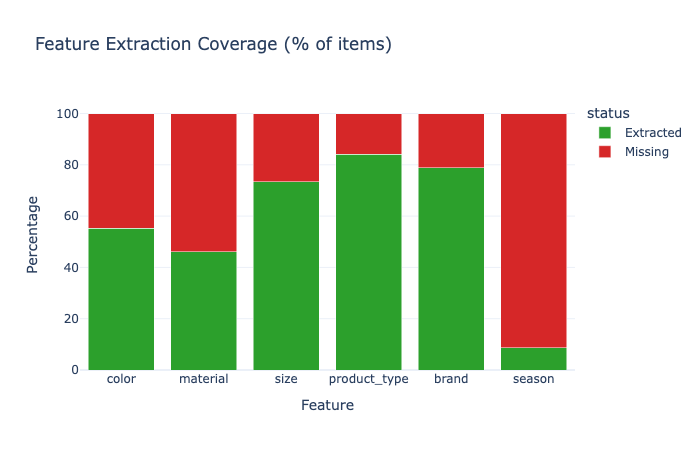

In [13]:
# Stacked bar chart: % extracted vs % missing for each feature
coverage_data = []
for col in feature_cols:
    filled = df[col].notna().mean() * 100
    coverage_data.append({"feature": col, "status": "Extracted", "pct": filled})
    coverage_data.append({"feature": col, "status": "Missing", "pct": 100 - filled})

cov_df = pd.DataFrame(coverage_data)

fig = px.bar(
    cov_df, x="feature", y="pct", color="status",
    title="Feature Extraction Coverage (% of items)",
    labels={"pct": "Percentage", "feature": "Feature"},
    color_discrete_map={"Extracted": "#2ca02c", "Missing": "#d62728"},
    template="plotly_white",
    barmode="stack",
)
fig.update_layout(height=450)
fig.write_image(str(IMG_DIR / "extraction_coverage.png"), scale=2)
fig.show()

In [14]:
# Value counts for extracted categorical features
for col in ["product_type", "color", "material", "brand"]:
    print(f"\n--- {col} ---")
    vc = df[col].value_counts()
    print(f"  Unique values: {len(vc)}")
    print(vc.head(15).to_string())


--- product_type ---
  Unique values: 21
product_type
botki          1914
sneakersy      1133
torebka         708
portfel         669
sandaly         597
kozaki          536
szpilki         512
mokasyny        354
polbuty         285
kowbojki        229
glany           216
trapery         211
portmonetka     205
listonoszka     168
baleriny        152

--- color ---
  Unique values: 21
color
czarny       2466
bezowy        823
czerwony      281
bialy         266
brazowy       259
zloty         173
taupe         166
rozowy        137
kamelowy      133
srebrny       132
szary         102
niebieski      97
granatowy      93
zielony        90
kremowy        72

--- material ---
  Unique values: 8
material
skorzany       2597
zamszowy       1081
lakierowany     557
wezowy          112
nubukowy        104
tekstylny        80
welurowy         13
ekoskora          1

--- brand ---
  Unique values: 8
brand
Monnari         2099
Sergio Leone    1603
Optimo          1441
Art             1005
Wola

## 6. Price Analysis by Category

Explore how item prices vary across extracted product types and brands.

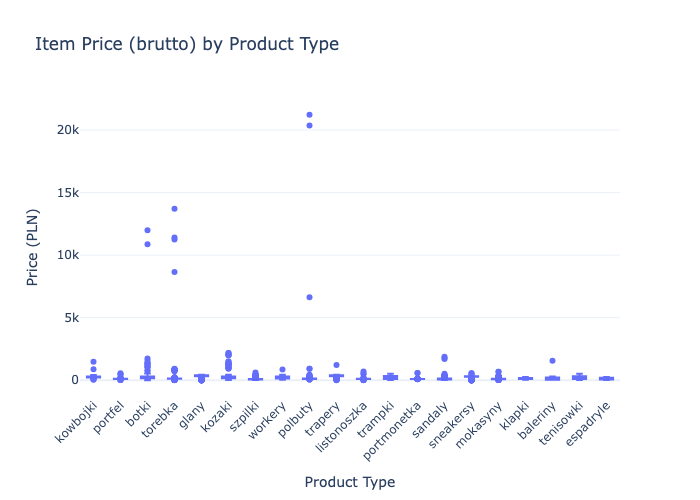

Price statistics by product type:
               count   mean    50%   min      max
product_type                                     
botki        1914.00 254.60 233.09  0.00 11980.00
sneakersy    1133.00 292.13 329.00  0.00   554.00
torebka       708.00 204.51 132.40  0.00 13710.00
portfel       669.00 107.30  99.99 23.33   550.00
sandaly       597.00 135.40  75.59 13.10  1880.00
kozaki        536.00 278.49 206.84 26.53  2170.00
szpilki       512.00 116.78  79.37 18.41   614.00
mokasyny      354.00 111.77 101.26 29.99   670.00
polbuty       285.00 302.69 119.11 51.51 21220.00
kowbojki      229.00 261.73 230.99 35.54  1473.00
glany         216.00 342.32 399.00  0.00   449.00
trapery       211.00 334.20 359.10  0.00  1224.00
portmonetka   205.00 107.79  99.76 83.99   577.00
listonoszka   168.00 113.83 106.56  0.00   692.00
baleriny      152.00 139.90  58.95 36.79  1567.00
klapki        124.00 133.57 124.66 32.77   259.92
tenisowki     119.00 221.85 263.20 21.99   524.00
trampki        9

In [15]:
# Boxplot: item_price_brutto by product_type (top categories only)
df_typed = df[df["product_type"].notna()].copy()

# Keep only product types with enough samples
type_counts = df_typed["product_type"].value_counts()
top_types = type_counts[type_counts >= 5].index.tolist()
df_typed_top = df_typed[df_typed["product_type"].isin(top_types)]

fig = px.box(
    df_typed_top, x="product_type", y="item_price_brutto",
    title="Item Price (brutto) by Product Type",
    labels={"product_type": "Product Type", "item_price_brutto": "Price (PLN)"},
    template="plotly_white",
)
fig.update_layout(height=500, xaxis_tickangle=-45)
fig.write_image(str(IMG_DIR / "price_by_product_type.png"), scale=2)
fig.show()

# Summary statistics
print("Price statistics by product type:")
print(df_typed_top.groupby("product_type")["item_price_brutto"]
      .describe()[["count", "mean", "50%", "min", "max"]]
      .sort_values("count", ascending=False)
      .to_string())

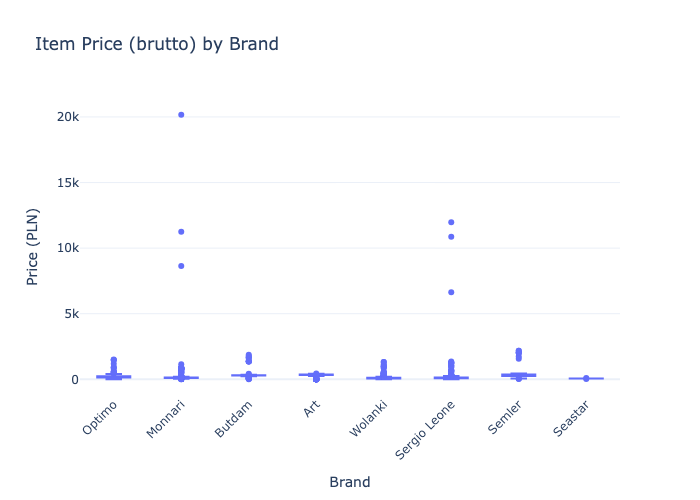

Price statistics by brand:
               count   mean    50%   min      max
brand                                            
Monnari      2099.00 145.38 115.49  0.00 20170.00
Sergio Leone 1603.00 135.25  94.54  0.00 11980.00
Optimo       1441.00 206.21 220.49  0.00  1513.00
Art          1005.00 340.24 369.00  0.00   449.00
Wolanki       675.00 115.74  83.34 13.10  1310.00
Butdam        669.00 315.27 296.10  0.00  1880.00
Semler        287.00 347.34 302.18 46.41  2170.00
Seastar         8.00  59.09  59.17 21.99    91.18


In [16]:
# Boxplot: item_price_brutto by brand
df_branded = df[df["brand"].notna()].copy()

if len(df_branded) > 0:
    fig = px.box(
        df_branded, x="brand", y="item_price_brutto",
        title="Item Price (brutto) by Brand",
        labels={"brand": "Brand", "item_price_brutto": "Price (PLN)"},
        template="plotly_white",
    )
    fig.update_layout(height=500, xaxis_tickangle=-45)
    fig.write_image(str(IMG_DIR / "price_by_brand.png"), scale=2)
    fig.show()

    print("Price statistics by brand:")
    print(df_branded.groupby("brand")["item_price_brutto"]
          .describe()[["count", "mean", "50%", "min", "max"]]
          .sort_values("count", ascending=False)
          .to_string())
else:
    print("No brand data extracted.")

## 7. SKU Pattern Analysis

SKU codes often encode brand and product line information via their prefixes.
Let's examine SKU structure and compare brand detection from SKU vs from name.

Items with SKU: 9,719 / 9,879 (98.4%)


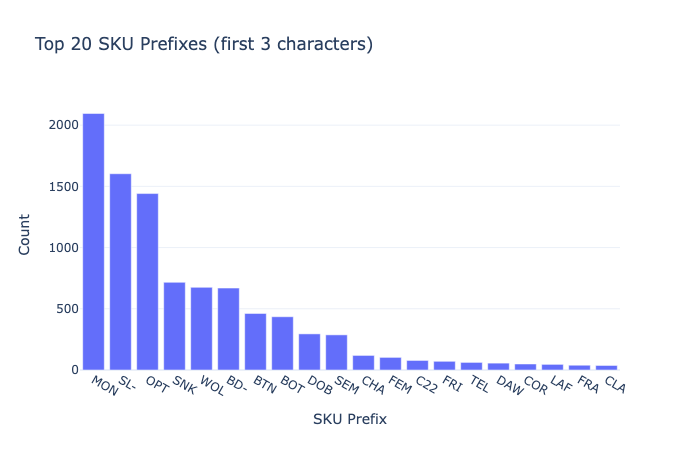


Configured SKU-to-brand mappings (10):
     OPT -> Optimo               (1,441 items)
     MON -> Monnari              (2,095 items)
      SL -> Sergio Leone         (1,603 items)
     WOL -> Wolanki              (675 items)
      BD -> Butdam               (669 items)
     SEM -> Semler               (287 items)
    bota -> Art                  (435 items)
     btn -> Art                  (462 items)
     SNK -> Art                  (46 items)
    TELA -> Art                  (62 items)


In [17]:
# SKU prefix distribution
df_sku = df[df["products_sku"].notna()].copy()
print(f"Items with SKU: {len(df_sku):,} / {len(df):,} ({100 * len(df_sku) / len(df):.1f}%)")

# Extract first 2-3 character prefix from SKU
df_sku["_sku_prefix"] = df_sku["products_sku"].astype(str).str[:3].str.upper()
prefix_counts = df_sku["_sku_prefix"].value_counts().head(20)

fig = px.bar(
    x=prefix_counts.index, y=prefix_counts.values,
    title="Top 20 SKU Prefixes (first 3 characters)",
    labels={"x": "SKU Prefix", "y": "Count"},
    template="plotly_white",
)
fig.update_layout(height=450)
fig.write_image(str(IMG_DIR / "sku_prefix_dist.png"), scale=2)
fig.show()

# Map known prefixes to brands from config
brand_prefixes = config["extraction"].get("brand_sku_prefixes", {})
print(f"\nConfigured SKU-to-brand mappings ({len(brand_prefixes)}):")
for prefix, brand in brand_prefixes.items():
    count = df_sku["products_sku"].astype(str).str.startswith(prefix).sum()
    print(f"  {prefix:>6s} -> {brand:20s} ({count:,} items)")

In [18]:
# Brand coverage: SKU-based vs name-based
# Re-extract brand from name only (without SKU) to compare
brand_from_name = []
brand_from_sku = []

for _, row in df.iterrows():
    name = str(row.get("name") or "")
    sku = row.get("products_sku")

    # Brand from name only
    brand_n = extractor.extract_brand(name, sku=None)
    brand_from_name.append(brand_n)

    # Brand from SKU only
    if sku and pd.notna(sku):
        sku_str = str(sku)
        brand_s = None
        for prefix, brand in extractor.brand_sku_prefixes.items():
            if sku_str.startswith(prefix):
                brand_s = brand
                break
        brand_from_sku.append(brand_s)
    else:
        brand_from_sku.append(None)

n_name = sum(1 for b in brand_from_name if b is not None)
n_sku = sum(1 for b in brand_from_sku if b is not None)
n_combined = df["brand"].notna().sum()

print("Brand detection sources:")
print(f"  From name only:  {n_name:>6,} ({100 * n_name / len(df):.1f}%)")
print(f"  From SKU only:   {n_sku:>6,} ({100 * n_sku / len(df):.1f}%)")
print(f"  Combined:        {n_combined:>6,} ({100 * n_combined / len(df):.1f}%)")

Brand detection sources:
  From name only:   4,115 (41.7%)
  From SKU only:    7,775 (78.7%)
  Combined:         7,787 (78.8%)


## 8. Seller Comments Analysis

Seller comments may contain additional product metadata, shipping notes,
or quality indicators.

Seller comments:   2,473 / 9,879 (25.0%)
Buyer comments:      143 / 9,879 (1.4%)


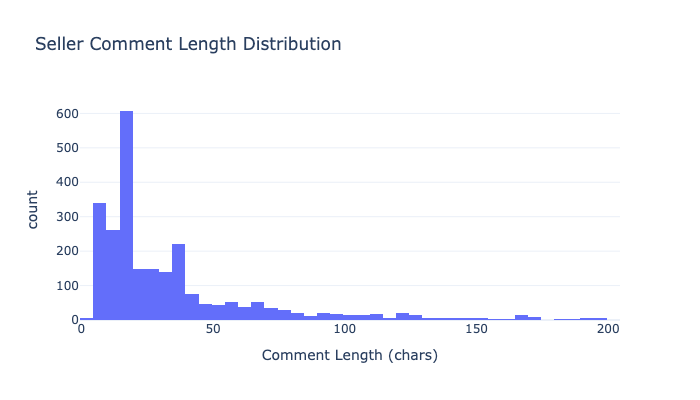


Seller comment length -- mean: 34.6, median: 20, max: 200


In [19]:
# Non-empty rate and comment length distribution
has_seller = df["seller_comments"].notna()
has_buyer = df["buyer_comments"].notna() if "buyer_comments" in df.columns else pd.Series([False] * len(df))

print(f"Seller comments:  {has_seller.sum():>6,} / {len(df):,} ({100 * has_seller.mean():.1f}%)")
print(f"Buyer comments:   {has_buyer.sum():>6,} / {len(df):,} ({100 * has_buyer.mean():.1f}%)")

# Comment length distribution (seller)
if has_seller.sum() > 0:
    seller_lens = df.loc[has_seller, "seller_comments"].str.len()
    fig = px.histogram(
        x=seller_lens, nbins=50,
        title="Seller Comment Length Distribution",
        labels={"x": "Comment Length (chars)", "y": "Count"},
        template="plotly_white",
    )
    fig.update_layout(height=400)
    fig.write_image(str(IMG_DIR / "seller_comment_length.png"), scale=2)
    fig.show()

    print(f"\nSeller comment length -- mean: {seller_lens.mean():.1f}, "
          f"median: {seller_lens.median():.0f}, max: {seller_lens.max()}")
else:
    print("No seller comments found.")

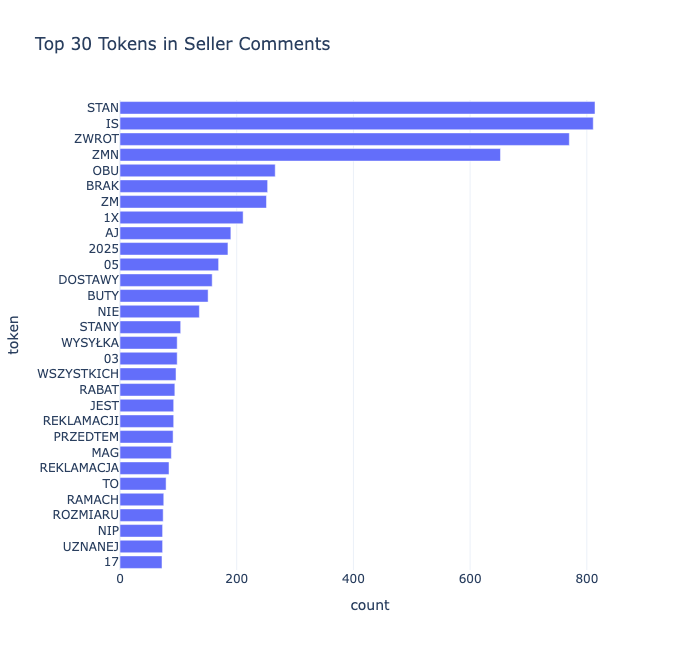

Total comment tokens: 12,312
Unique comment tokens: 1,694


In [20]:
# Most common words in seller comments
if has_seller.sum() > 0:
    comment_tokens = []
    for comment in df.loc[has_seller, "seller_comments"]:
        normalized = normalize_text(comment)
        tokens = tokenize(normalized, min_length=2)
        tokens = remove_stopwords(tokens)
        comment_tokens.extend(tokens)

    comment_counts = Counter(comment_tokens).most_common(30)
    comment_df = pd.DataFrame(comment_counts, columns=["token", "count"])

    fig = px.bar(
        comment_df, x="count", y="token", orientation="h",
        title="Top 30 Tokens in Seller Comments",
        template="plotly_white",
    )
    fig.update_layout(height=650, yaxis=dict(autorange="reversed"))
    fig.write_image(str(IMG_DIR / "seller_comment_tokens.png"), scale=2)
    fig.show()

    print(f"Total comment tokens: {len(comment_tokens):,}")
    print(f"Unique comment tokens: {len(set(comment_tokens)):,}")
else:
    print("No seller comments to analyze.")

## 9. Summary of Key Findings

| Finding | Details | Impact on Pipeline |
|---------|---------|-------------------|
| **Product name structure** | Names are short Polish descriptions with embedded attributes (color, material, type, size) | Tokenization + dictionary matching is a viable extraction strategy |
| **Feature extraction coverage** | product_type and color have the highest coverage; brand and season are sparser | May need additional rules or ML-based extraction for low-coverage features |
| **SKU-based brand detection** | SKU prefixes provide reliable brand mapping for configured prefixes | Complements name-based brand extraction; combined approach is best |
| **Price variation** | Significant price differences across product types and brands | Extracted features carry real discriminative value |
| **N-gram patterns** | Common bigrams/trigrams reveal frequent product attribute combinations | Useful for TF-IDF feature engineering and category definition |
| **Seller comments** | Variable presence and content; may contain supplementary product info | Worth monitoring but not a primary feature source |

**Next steps:**
1. Build TF-IDF + extracted features combined matrix for ML categorization
2. Expand extraction dictionaries where coverage is low
3. Train and evaluate classification models (SVM, RF, XGBoost) on product_type
4. Use the champion model to predict missing product types